In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sklearn.neural_network
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import sklearn.model_selection
import sklearn.metrics
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def FrankeFunction(x,y): #Definition of the Franke function with a noise
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x)) #noise defined with the normal distribution N(0,0.1)
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise

def create_X(x, y, n ):  #creation of the matrix X
    if len(x.shape) > 1:
            x = np.ravel(x)   #gives a 1D array
            y = np.ravel(y)
    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

def R2(y_data, y_model):  #function to determine de R2 score of the fit 
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data, y_model): #function to determine the mean squarred error of the fit 
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n


N = 100 #Number of data
seed = 31415
np.random.seed(seed)

x = np.sort(np.random.uniform(0, 1, N)) #sort data to plot correctly
y = np.sort(np.random.uniform(0, 1, N))
x, y = np.meshgrid(x,y)  #x et y dim = 2, Creates a grid for the evaluation of the 2 dimension Franke's function
z = FrankeFunction(x, y)

x_dim1 = x.ravel() #dim =1
y_dim1 = y.ravel() #dim =1
z_dim1 = z.ravel() #dim =1

#Max polynomial order
n = 10
#Set number of folds
k = 100

#Creating list to store the results 
mean_test_error=[]
mean_train_error=[]
mean_test_r2=[]
mean_train_r2=[]
bias = []
variance = []
bias_variance = []


for poly in range (1,n+1): #loop for the polynomial order

    testing_error=[]
    training_error =[]
    testing_r2=[]
    training_r2 =[]
    Z_predict=[]

    # Create the design matrix
    X = create_X(x_dim1,y_dim1, poly)


    #Scaling of the data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    #Make train and test data using the folds made by SKlearn
    X_train, X_test, z_train_1, z_test_1 = sklearn.model_selection.train_test_split(X, z_dim1, test_size=0.2)
    
    
    #Make folds using SKlearn
    kf = KFold(n_splits=k, shuffle=True) #no random_state=42, shuffle=True set
    kf.get_n_splits(X_scaled)

    # Implement neural network with scikit learn
    clf = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 20),learning_rate="adaptive",learning_rate_init=0.01,max_iter=1000,tol=1e-7,verbose=False,)
    clf = clf.fit(X_train, z_train_1)
    
    # Begin iterations for the cross-valiation method 
    i = 0
    for train_index, test_index in kf.split(X_scaled):
        # #Make train and test data using the folds made by SKlearn
        X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
        z_train, z_test = z.ravel()[train_index], z.ravel()[test_index]
    
        #filling lists with the result for each fold
        testing_error.append(MSE(z_test, clf.predict(X_test_scaled)))
        training_error.append(MSE(z_train, clf.predict(X_train_scaled)))
        testing_r2.append(R2(z_test,clf.predict(X_test_scaled)))
        training_r2.append(R2(z_train,clf.predict(X_train_scaled)))
        Z_predict.append(clf.predict(X_test_scaled))

        #Prediction of the z value using OLS model
        zpred = clf.predict(X) #dim = 1
        
        #Reshaping array without changing the data
        zplot = zpred.reshape(N, N) #dim =2

        i += 1
        
    #Prediction of the z value using OLS model
    zpred = clf.predict(X) #dim = 1
        
    #Reshaping array without changing the data
    zplot = zpred.reshape(N, N) #dim =2

    print('Polynomial degree:', poly)
    print("MSE: {:.2f}".format(MSE(z_test,clf.predict(X_test_scaled))))
    print("R2: {:.2f}".format(R2(z_test,clf.predict(X_test_scaled))))
    
    #Getting global results for each polynome degree
    variance.append(np.mean(np.var(Z_predict, axis=0, keepdims=True)))
    bias.append(np.mean( (z_test - np.mean(Z_predict, axis=0, keepdims=True))**2 ))
    bias_variance.append(variance[poly-1]+bias[poly-1])
    mean_test_error.append(np.mean(testing_error))
    mean_train_error.append(np.mean(training_error))
    mean_test_r2.append(np.mean(testing_r2))
    mean_train_r2.append(np.mean(training_r2))

Polynomial degree: 1
MSE: 0.17
R2: -0.72
Polynomial degree: 2
MSE: 0.11
R2: -0.09
Polynomial degree: 3
MSE: 0.04
R2: 0.60
Polynomial degree: 4
MSE: 0.06
R2: 0.39
Polynomial degree: 5
MSE: 0.04
R2: 0.58
Polynomial degree: 6
MSE: 0.04
R2: 0.53
Polynomial degree: 7
MSE: 0.04
R2: 0.53
Polynomial degree: 8
MSE: 0.06
R2: 0.40
Polynomial degree: 9
MSE: 0.05
R2: 0.48
Polynomial degree: 10
MSE: 0.04
R2: 0.61


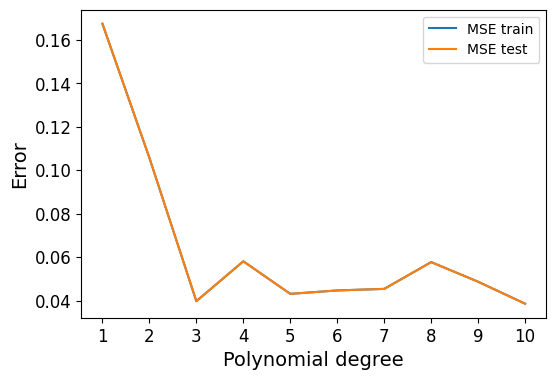

In [2]:
plt.figure(figsize=(6,4))
plt.plot(mean_train_error, label="MSE train")
plt.plot(mean_test_error, label="MSE test")
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8,9],["1","2","3","4","5","6","7","8","9","10"], fontsize=12)
plt.xlabel("Polynomial degree", fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

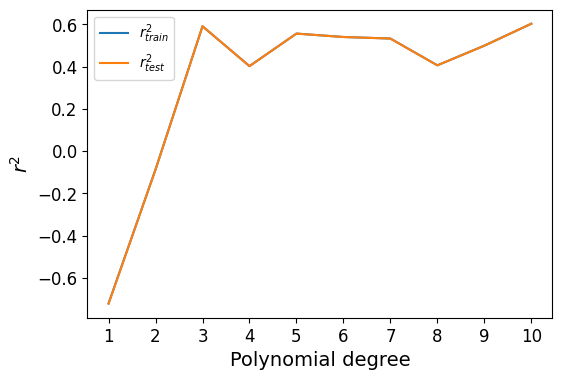

In [3]:
plt.figure(figsize=(6,4))
plt.plot(mean_train_r2, label=r'$r^2_{train}$')
plt.plot(mean_test_r2, label=r'$r^2_{test}$')
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8,9],["1","2","3","4","5","6","7","8","9","10"], fontsize=12)
plt.xlabel("Polynomial degree", fontsize=14)
plt.ylabel(r'$r^2$', fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

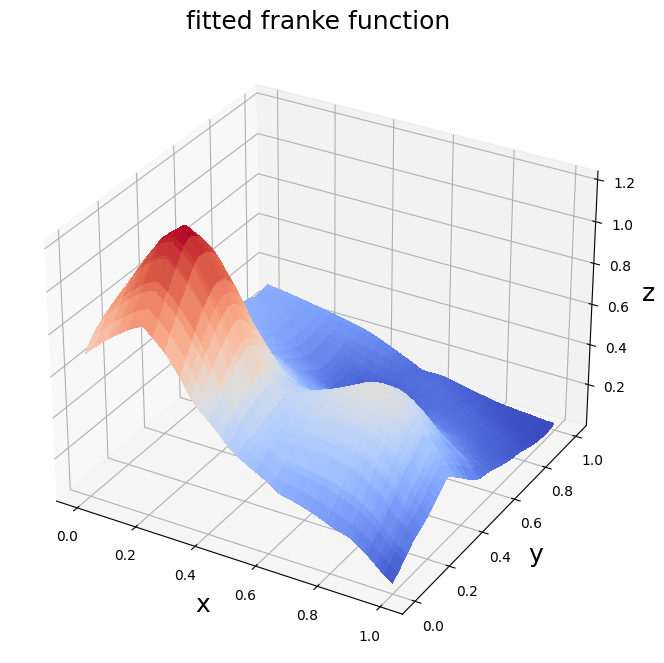

In [4]:
#plot result fit
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,zplot,cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)
ax.set_title('fitted franke function', fontsize=18)
plt.show()

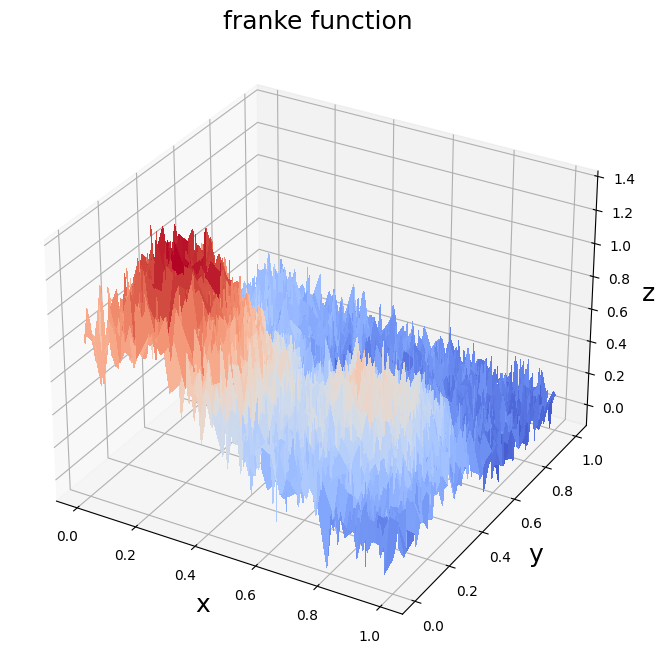

In [5]:
#plot franke function
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.set_zlim(-0.10, 1.40)
ax.plot_surface(x,y,z,cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18)
ax.set_title('franke function', fontsize=18)
plt.show()